# M15 Calibration Notebook — Reward Convergence & Online Policy Dynamics
This notebook demonstrates:
1. EMA reward convergence per (macro, micro, side).
2. Online TinyMLP decision boundary shift under feedback.
3. Safety diagnostics for online learning.

_Generated automatically — copy into your repo's `/notebooks/` folder or run here._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, deque

np.random.seed(7)

class EMATable:
    def __init__(self, alpha=0.02):
        self.alpha=float(alpha); self.avg=defaultdict(float); self.n=defaultdict(int)
    def update(self, key, reward: float):
        a=self.alpha; self.avg[key]=(1-a)*self.avg[key]+a*reward; self.n[key]+=1
    def get(self,key,default=0.0):
        return self.avg.get(key, default)

class TinyMLP:
    def __init__(self, d_in:int, d_hidden:int=16, seed:int=7):
        rng = np.random.default_rng(seed)
        self.W1 = rng.normal(0, 0.05, (d_in, d_hidden))
        self.b1 = np.zeros(d_hidden)
        self.W2 = rng.normal(0, 0.05, (d_hidden, 1))
        self.b2 = np.zeros(1)
    def _forward(self, x):
        h = np.tanh(x @ self.W1 + self.b1)
        z = h @ self.W2 + self.b2
        y = 1/(1+np.exp(-z))
        return h, y
    def predict_proba(self, x):
        _, y = self._forward(x)
        return y.ravel()
    def step(self, x, y_true, lr=1e-4, clip=0.05):
        h, y = self._forward(x)
        dz = (y - y_true.reshape(-1,1))
        dW2 = h.T @ dz / len(x); db2 = dz.mean(0)
        dh = dz @ self.W2.T * (1 - h**2)
        dW1 = x.T @ dh / len(x); db1 = dh.mean(0)
        for g in (dW1, db1, dW2, db2):
            import numpy as _np
            _np.clip(g, -clip, clip, out=g)
        self.W1 -= lr * dW1; self.b1 -= lr * db1
        self.W2 -= lr * dW2; self.b2 -= lr * db2

def generate_synthetic_stream(T=4000, d=6):
    macro = np.random.choice([0,1,2], size=T, p=[0.3,0.4,0.3])
    micro = np.random.choice([0,1], size=T)
    x = np.random.normal(0,1,(T,d))
    sig = (macro==2).astype(float) - (macro==0).astype(float) + 0.3*(micro*2-1)
    x[:,0] += 0.8*sig + 0.2*np.random.normal(size=T)
    p_buy = 0.5 + 0.15*(macro==2) - 0.15*(macro==0) + 0.05*(micro*2-1)
    y_buy = (np.random.rand(T) < p_buy).astype(int)
    pnl_buy = (y_buy*2-1) * (0.5 + 0.5*np.random.rand(T))
    pnl_sell = -pnl_buy
    return macro, micro, x, pnl_buy, pnl_sell

T=4000; d=6
macro, micro, X, pnl_buy, pnl_sell = generate_synthetic_stream(T=T, d=d)
import pandas as pd
df = pd.DataFrame({"macro":macro, "micro":micro, "pnl_buy":pnl_buy, "pnl_sell":pnl_sell})
df.head()

,macro,micro,pnl_buy,pnl_sell
0,0,1,-0.698619,0.698619
1,2,0,0.664708,-0.664708
2,1,1,0.803564,-0.803564
3,2,0,0.890670,-0.890670
4,2,1,-0.795908,0.795908


## 1) EMA Reward Convergence per (macro, micro, side)

In [2]:
alpha = 0.02
R_state = EMATable(alpha); R_side = EMATable(alpha)
def update_rewards(m, s, side, delta):
    R_state.update((m,s), delta)
    R_side.update((m,s,side), delta)

sides = np.where(X[:,0]>0, 'BUY', 'SELL')
delta = np.where(sides=='BUY', pnl_buy, pnl_sell)
for i in range(T):
    update_rewards(int(macro[i]), int(micro[i]), sides[i], float(delta[i]))

rows = []
for M in range(3):
    for S in range(2):
        rows.append({'macro':M,'micro':S,
            'reward_state': R_state.get((M,S),0.0),
            'reward_buy': R_side.get((M,S,'BUY'),0.0),
            'reward_sell': R_side.get((M,S,'SELL'),0.0),
        })
R_df = pd.DataFrame(rows)
R_df

,macro,micro,reward_state,reward_buy,reward_sell
0,0,0,0.229532,-0.270029,0.342424
1,0,1,0.157235,-0.125175,0.177879
2,1,0,-0.045341,-0.138760,0.004341
3,1,1,0.065925,-0.052751,0.121152
4,2,0,0.118093,0.232877,-0.146368
5,2,1,0.223228,0.332115,-0.277883


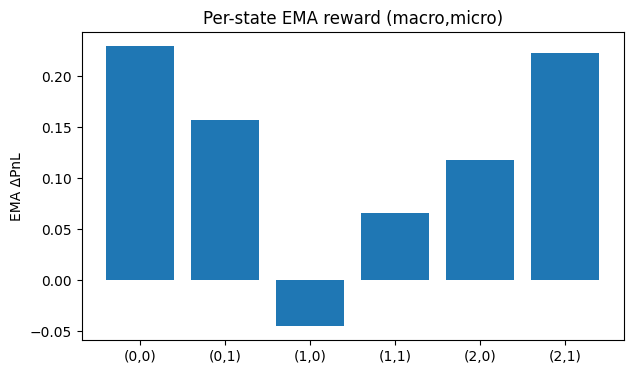

In [3]:
fig, ax = plt.subplots(figsize=(7,4))
ax.set_title('Per-state EMA reward (macro,micro)')
ax.bar(np.arange(len(R_df)), R_df['reward_state'].values)
ax.set_xticks(np.arange(len(R_df)))
ax.set_xticklabels([f"({m},{s})" for m,s in zip(R_df['macro'], R_df['micro'])])
ax.set_ylabel('EMA ΔPnL')
plt.show()

## 2) Online TinyMLP: Decision Boundary Shift

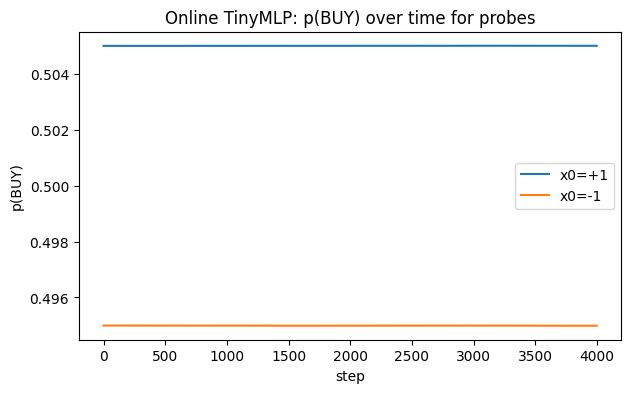

In [4]:
mlp = TinyMLP(d_in=d, d_hidden=16)
batch=64; lr=1e-4; clip=0.05
bufx, bufy = deque(maxlen=5000), deque(maxlen=5000)
def step_online(i):
    label = 1 if pnl_buy[i] > pnl_sell[i] else 0
    bufx.append(X[i]); bufy.append(label)
    if len(bufx) >= batch and (i % 100 == 0):
        import numpy as _np
        idx = _np.random.choice(len(bufx), size=batch, replace=False)
        Xb = _np.stack([bufx[j] for j in idx], axis=0)
        yb = _np.asarray([bufy[j] for j in idx], dtype=_np.float32)
        mlp.step(Xb, yb, lr=lr, clip=clip)

probes = {"x0=+1": np.array([1,0,0,0,0,0],dtype=np.float32),
          "x0=-1": np.array([-1,0,0,0,0,0],dtype=np.float32)}
probs_log = {k:[] for k in probes}
for i in range(T):
    step_online(i)
    for k,xv in probes.items():
        probs_log[k].append(float(mlp.predict_proba(xv[None,:])[0]))

fig, ax = plt.subplots(figsize=(7,4))
ax.set_title('Online TinyMLP: p(BUY) over time for probes')
ax.plot(probs_log['x0=+1'])
ax.plot(probs_log['x0=-1'])
ax.set_xlabel('step'); ax.set_ylabel('p(BUY)')
ax.legend(['x0=+1','x0=-1'])
plt.show()

## 3) Safety Diagnostics

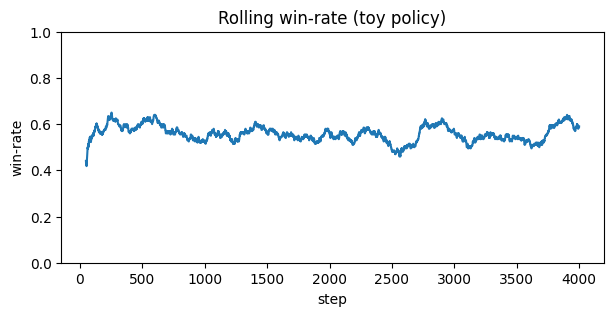

0.59

In [5]:
wins = ((X[:,0]>0) & (pnl_buy>pnl_sell)) | ((X[:,0]<=0) & (pnl_sell>pnl_buy))
win_rate = pd.Series(wins.astype(int)).rolling(200, min_periods=50).mean()
fig, ax = plt.subplots(figsize=(7,3))
ax.set_title('Rolling win-rate (toy policy)')
ax.plot(win_rate.values)
ax.set_ylim(0,1); ax.set_xlabel('step'); ax.set_ylabel('win-rate')
plt.show()
float(win_rate.dropna().iloc[-1])

### Notes
- Replace synthetic stream with real `feedback_log.csv` to validate on live data.
- Keep LR small (`1e-4`) and use cooldown between updates in production.
- Freeze online updates if rolling win-rate drops below threshold.